<a href="https://colab.research.google.com/github/timmooren/hispa-cancer-detection/blob/main/code/hispa_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathologic Cancer Detection




Notebook structure:

We have ran and evaluated a large number of models during this project. All the models can be found in the table of contents for easier navigation. Some graphs have small analysis written below, but the most thorough and leading analyses can be found back in the final report.

In [11]:
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
from google.colab import files
from sklearn.metrics import plot_confusion_matrix

The cell below will promt you for a kaggle.json file. This file is needed for the Kaggle API.
For more information on how to download your own kaggle.json file, please see:
https://www.kaggle.com/docs/api

In [ ]:
#this will prompt you to upload the kaggle.json
files.upload()  

# Downloading data

The cell below will install the Kaggle package and move kaggle.json to the appropriate folder.

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

     |████████████████████████████████| 61kB 6.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=4e410f1fd276ef77c391fc3096403f1dc9893e30e58008ee9b824573be864db4
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json


The cell below downloads and unzips the data

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -qq histopathologic-cancer-detection.zip

100% 6.30G/6.31G [01:42<00:00, 76.3MB/s]
100% 6.31G/6.31G [01:42<00:00, 65.9MB/s]


# Loading data

Load train_labels.csv and image id's to their respective label.

In [5]:
labels_csv = pd.read_csv('train_labels.csv')
id2label = dict(zip(labels_csv.id, labels_csv.label))

Get the filepaths of all the images and divide them into training and validation data.

In [6]:
# get filepaths of all the images
file_paths = glob.glob('train/*.tif')
# split the filepaths into train and validation data
train_paths, val_paths = train_test_split(file_paths, test_size=0.3, random_state=1)

Prepare training and validation data. Images are resized from 96x96 to 48x48 due to memory constraints.

Inspiration was taken from NN_gtsrb notebook, but we hoped to make it more memory-effiecient by initializing a Numpy-zeros array, rather than converting a regular Python list to a Numpy array. We would love to hear your feedback on whether this makes a difference.

In [7]:
def crop_ROI(image, size):
    """
    Crops image to region of interest.
    Only allows for 32x32 and 48x48 crop.
    """
    assert size == 32 or size == 48
    if size==48:
        x1, y1 = 23, 23
        x2, y2 = 71, 71
    else:
        x1, y1 = 31, 31
        x2, y2 = 63, 63

    return image[y1:y2, x1:x2]

def load_data(image_paths, ROI=False, size=32):
    """
    Prepares data for training or validation.

    Arguments:  
    File paths of relevant images as list.
    ROI enabled or not
    size of the final image (only 32x32 or 48x48 possible) 

    Returns: A tuple containing:
        - Four dimensional Numpy array containing all the images (ready for training).
        - Targets
    """
    target_list = []
    image_list  = np.zeros((len(image_paths), size, size, 3))

    for index, image_path in enumerate(image_paths):
            # image id is equal to the filename
            id = image_path[6:-4]
            # get relevant label
            target = id2label[id]
            # add target to the list
            target_list.append(target)
            # crop ROI if requested
            if ROI:
                image = crop_ROI(cv2.imread(image_path), size)
            else:
                image = cv2.resize(cv2.imread(image_path), (size, size))
            # add image to the list
            image_list[index] = image

    # convert to one-hot encoding
    targets = tf.keras.utils.to_categorical(target_list)

    return (image_list, targets)


train_images, train_labels = load_data(train_paths)
val_images, val_labels = load_data(val_paths)

print(f'Training images loaded: {train_images.shape}')
print(f'Training labels loaded: {train_labels.shape}')
print(f'Testing images loaded: {val_images.shape}')
print(f'Testing labels loaded: {val_labels.shape}')

Training images loaded: (154017, 32, 32, 3)
Training labels loaded: (154017, 2)
Testing images loaded: (66008, 32, 32, 3)
Testing labels loaded: (66008, 2)


Source of code below: CNN_gtsrb notebook.
We added the recall metric, and the option to change the learning rate & batch size.




In [12]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}, l_rate=0.001, batch_size=None):
    """
    Trains and evaluates a model based on training and testing data, and their respective labels.
    Preprocessing and data augmentation can be added trough their respective arguments.
    """
    opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
    opt_adelta = tf.keras.optimizers.Adadelta(learning_rate=l_rate, rho=0.95, epsilon=1e-07, name='Adadelta')
    model.compile(loss='categorical_crossentropy', optimizer=opt_adelta, metrics=['accuracy', metrics.Recall(name='recall', class_id=1)])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y), batch_size=batch_size)
    fig, axs = plt.subplots(1,3,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy', 'recall']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    return model

# Model 1: Base model


For our base model, we made a simple convolutional neural network with the following architecture:

- 2 convolutional and max pooling layers
- 1 flatten layer
- 1 hidden layer
- 1 output layer

## 1a: Base model with learning rate = 0.001


Epoch 1/20
4814/4814 [==============================] - 83s 17ms/step - loss: 0.6835 - accuracy: 0.7753 - val_loss: 0.4467 - val_accuracy: 0.7971
Epoch 2/20
4814/4814 [==============================] - 83s 17ms/step - loss: 0.4396 - accuracy: 0.8016 - val_loss: 0.4116 - val_accuracy: 0.8144
Epoch 3/20
4814/4814 [==============================] - 81s 17ms/step - loss: 0.3996 - accuracy: 0.8232 - val_loss: 0.4065 - val_accuracy: 0.8185
Epoch 4/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3778 - accuracy: 0.8338 - val_loss: 0.3995 - val_accuracy: 0.8242
Epoch 5/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3616 - accuracy: 0.8411 - val_loss: 0.3819 - val_accuracy: 0.8319
Epoch 6/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3506 - accuracy: 0.8469 - val_loss: 0.3634 - val_accuracy: 0.8410
Epoch 7/20
4814/4814 [==============================] - 81s 17ms/step - loss: 0.3419 - accuracy: 0.8519 - val_loss: 0.3758 -

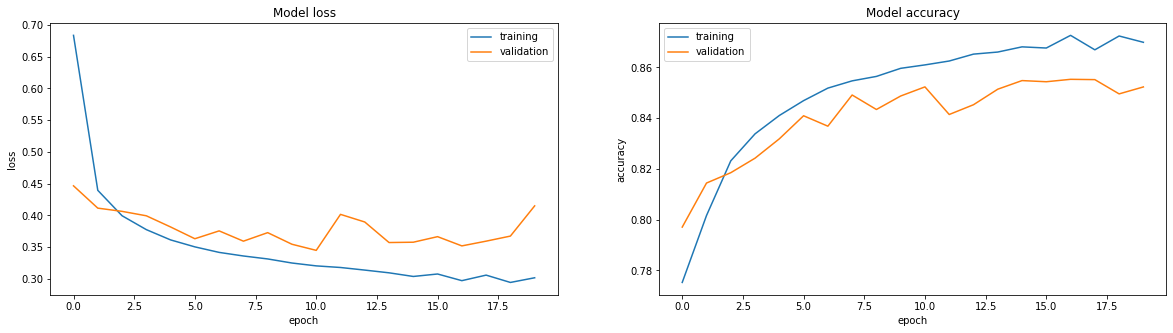

2063/2063 [==============================] - 9s 4ms/step - loss: 0.4151 - accuracy: 0.8523
Validation Accuracy: 0.8523209095001221


In [ ]:
# Base model with learning rate = 0.001
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels)

**Analysis of the graph above (Baseline model):**

The graph for our baseline model looks very promising, as both the training and the testing accuracy are increasing on a similar scale. 

One thing we found odd is that the validation data is fluctuating quite a bit. We aim to solve this in future models.

Although the training and validation accuracy is increasing in the first 20 epochs, the slope of both lines becomes rather flat. In order to increase the speed of learning, we will preprocess the data in model 2. We hope that this will make the training accuracy line steeper by increasing the gain in accuracy per epoch.

## 1b: Base model (learning rate = 0.01)


Epoch 1/15
4814/4814 [==============================] - 33s 7ms/step - loss: 3.8504 - accuracy: 0.5941 - val_loss: 0.6751 - val_accuracy: 0.5947
Epoch 2/15
4814/4814 [==============================] - 33s 7ms/step - loss: 0.6755 - accuracy: 0.5951 - val_loss: 0.6757 - val_accuracy: 0.5947
Epoch 3/15
4814/4814 [==============================] - 33s 7ms/step - loss: 0.6755 - accuracy: 0.5951 - val_loss: 0.6755 - val_accuracy: 0.5947
Epoch 4/15
4814/4814 [==============================] - 33s 7ms/step - loss: 0.6754 - accuracy: 0.5951 - val_loss: 0.6758 - val_accuracy: 0.5947
Epoch 5/15
4814/4814 [==============================] - 34s 7ms/step - loss: 0.6754 - accuracy: 0.5951 - val_loss: 0.6765 - val_accuracy: 0.5947
Epoch 6/15
4814/4814 [==============================] - 40s 8ms/step - loss: 0.6754 - accuracy: 0.5951 - val_loss: 0.6761 - val_accuracy: 0.5947
Epoch 7/15
4814/4814 [==============================] - 34s 7ms/step - loss: 0.6754 - accuracy: 0.5951 - val_loss: 0.6769 - val_ac

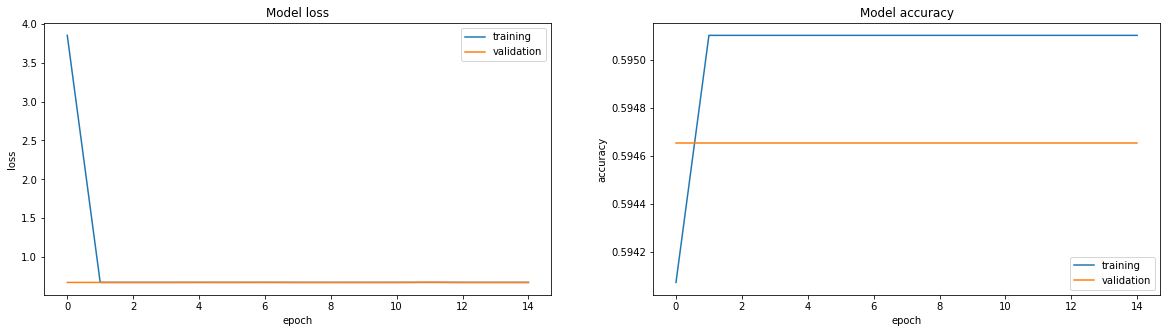

2063/2063 [==============================] - 5s 3ms/step - loss: 0.6755 - accuracy: 0.5947
Validation Accuracy: 0.5946552157402039


In [ ]:
# base model with learning rate = 0.01
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, l_rate=0.01, epochs=15)

**Analysis of graph above (Baseline model wiht learning rate = 0.01):**

Increasing the learning rate from 0.001 to 0.01 is definitely not an improvement on the previous model. It looks like the algorithm is diverging rather than converging. For now, we will leave the learning rate at 0.001 and try other adjustments of the CNN.

# Model 2: Preprocessing



As an attempt to make the network learn faster, we applied featurewise center and featurewise standard normalization to the input images.

## 2a: Preprocessing (input = 32x32)

Epoch 1/20
4814/4814 [==============================] - 81s 11ms/step - loss: 0.4443 - accuracy: 0.7973 - val_loss: 0.3894 - val_accuracy: 0.8269
Epoch 2/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3900 - accuracy: 0.8263 - val_loss: 0.3732 - val_accuracy: 0.8360
Epoch 3/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3676 - accuracy: 0.8378 - val_loss: 0.3764 - val_accuracy: 0.8398
Epoch 4/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3454 - accuracy: 0.8496 - val_loss: 0.3441 - val_accuracy: 0.8502
Epoch 5/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3298 - accuracy: 0.8566 - val_loss: 0.3571 - val_accuracy: 0.8481
Epoch 6/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3152 - accuracy: 0.8632 - val_loss: 0.3394 - val_accuracy: 0.8529
Epoch 7/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3010 - accuracy: 0.8707 - val_loss: 0.3416 -

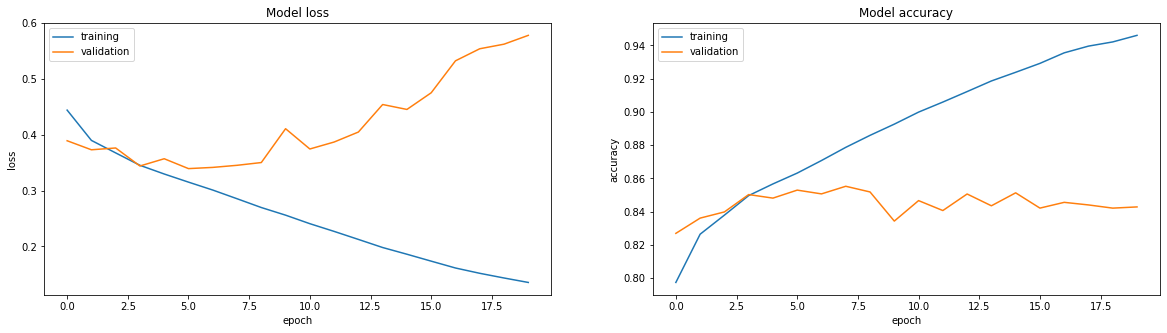

2063/2063 [==============================] - 10s 5ms/step - loss: 0.5782 - accuracy: 0.8428
Validation Accuracy: 0.8427766561508179


In [ ]:
# Preprocessing (input = 32x32)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True})

## 2b: Preprocessing (input = 48x48)

Epoch 1/20
4814/4814 [==============================] - 608s 126ms/step - loss: 0.4545 - accuracy: 0.7939 - val_loss: 0.5021 - val_accuracy: 0.7670
Epoch 2/20
4814/4814 [==============================] - 314s 65ms/step - loss: 0.3893 - accuracy: 0.8274 - val_loss: 0.3676 - val_accuracy: 0.8414
Epoch 3/20
4814/4814 [==============================] - 296s 61ms/step - loss: 0.3533 - accuracy: 0.8451 - val_loss: 0.3493 - val_accuracy: 0.8463
Epoch 4/20
4814/4814 [==============================] - 328s 68ms/step - loss: 0.3326 - accuracy: 0.8564 - val_loss: 0.4057 - val_accuracy: 0.8218
Epoch 5/20
4814/4814 [==============================] - 296s 61ms/step - loss: 0.3190 - accuracy: 0.8630 - val_loss: 0.3329 - val_accuracy: 0.8564
Epoch 6/20
4814/4814 [==============================] - 285s 59ms/step - loss: 0.3015 - accuracy: 0.8707 - val_loss: 0.3398 - val_accuracy: 0.8575
Epoch 7/20
4814/4814 [==============================] - 285s 59ms/step - loss: 0.2883 - accuracy: 0.8776 - val_loss: 

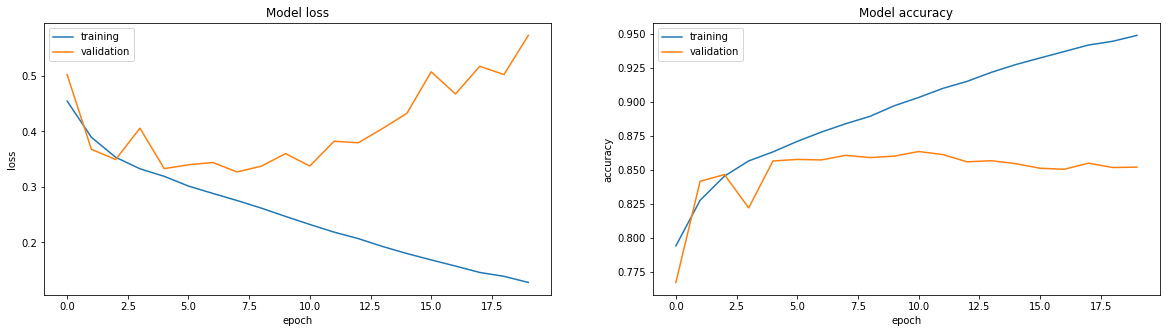

2063/2063 [==============================] - 10s 5ms/step - loss: 0.5728 - accuracy: 0.8518
Validation Accuracy: 0.8518210053443909


In [ ]:
# Preprocessing (input = 48x48)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True})

**Analysis of above graphs (Preprocessing with 32x32 and 48x48 input):**

Thanks to the normalization of the input data, the network was able to learn much quicker. This can be seen by the rapid increase in training accuracy as compared to the previous model. 

However, the validation accuracy reaches a plateau at some point, while the training data increases steadily. This is a sign that the model is overfitting to the training data. The overfitting starts around epoch 3 (as seen by the naked eye).



---





# Model 3: Dropout

In order to counteract the overfitting seen in the last model, we will add dropout to the network to increase robustness of the network.


## 3a: Dropout (input = 32x32)

Epoch 1/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.4625 - accuracy: 0.7898 - val_loss: 0.4119 - val_accuracy: 0.8146
Epoch 2/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.4121 - accuracy: 0.8183 - val_loss: 0.3919 - val_accuracy: 0.8275
Epoch 3/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3924 - accuracy: 0.8279 - val_loss: 0.3636 - val_accuracy: 0.8401
Epoch 4/30
4814/4814 [==============================] - 28s 6ms/step - loss: 0.3795 - accuracy: 0.8349 - val_loss: 0.3881 - val_accuracy: 0.8259
Epoch 5/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3726 - accuracy: 0.8393 - val_loss: 0.3748 - val_accuracy: 0.8300
Epoch 6/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3664 - accuracy: 0.8422 - val_loss: 0.3441 - val_accuracy: 0.8534
Epoch 7/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3631 - accuracy: 0.8428 - val_loss: 0.3911 - val_ac

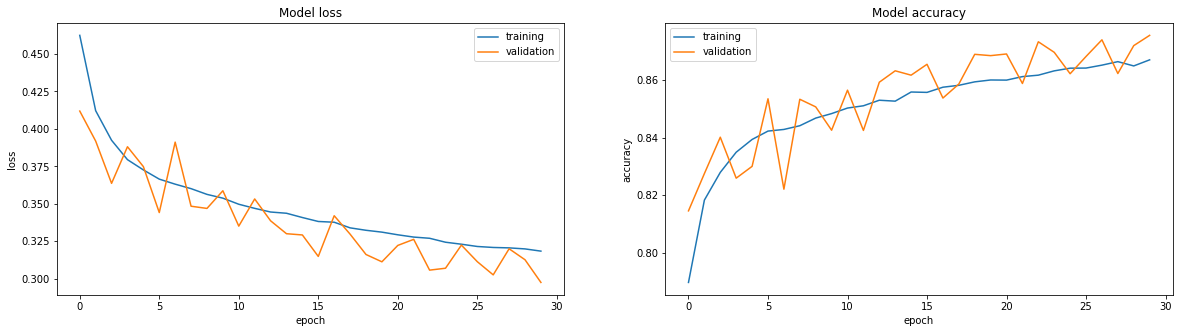

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2974 - accuracy: 0.8754
Validation Accuracy: 0.8754242062568665


In [ ]:
# 3a: Dropout (input = 32x32)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, epochs=50, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}) 

## 3b: Dropout (input = 48x48)

Epoch 1/30
4814/4814 [==============================] - 109s 22ms/step - loss: 0.4661 - accuracy: 0.7919 - val_loss: 0.4679 - val_accuracy: 0.7990
Epoch 2/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.4080 - accuracy: 0.8209 - val_loss: 0.4586 - val_accuracy: 0.8039
Epoch 3/30
4814/4814 [==============================] - 110s 23ms/step - loss: 0.3865 - accuracy: 0.8329 - val_loss: 0.3987 - val_accuracy: 0.8326
Epoch 4/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3719 - accuracy: 0.8393 - val_loss: 0.3906 - val_accuracy: 0.8298
Epoch 5/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3627 - accuracy: 0.8430 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 6/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3553 - accuracy: 0.8466 - val_loss: 0.4056 - val_accuracy: 0.8153
Epoch 7/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3517 - accuracy: 0.8490 - val_loss: 0

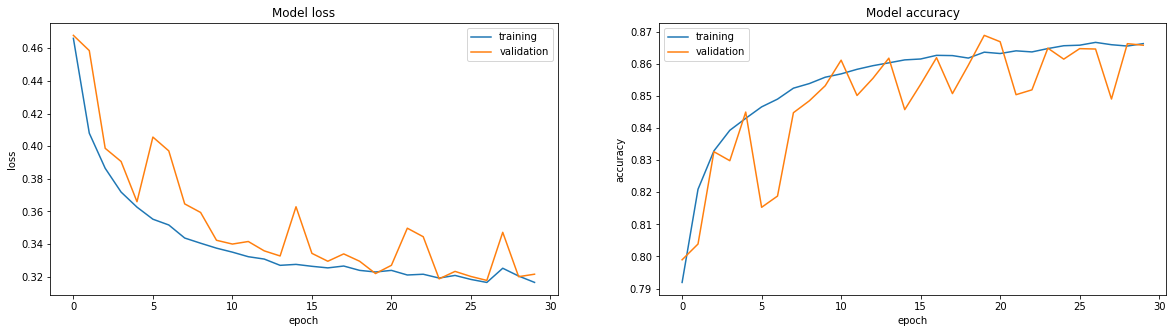

2063/2063 [==============================] - 10s 5ms/step - loss: 0.3216 - accuracy: 0.8658
Validation Accuracy: 0.865788996219635


In [ ]:
## 3b: Dropout (input = 48x48)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, epochs=30, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}) 

**Analysis of the graph above (Dropout):**

In correspondance with our hypothesis, the validation and training accuracy are roughly on the same line and scale again.

# Model 4: Deeper network
Now that we solved overfitting in the previous model, we will make an attempt to make the network deeper.

## 4a: Deeper network (input = 32x32)


Epoch 1/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.4528 - accuracy: 0.7941 - val_loss: 0.4081 - val_accuracy: 0.8113
Epoch 2/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.4023 - accuracy: 0.8229 - val_loss: 0.4066 - val_accuracy: 0.8183
Epoch 3/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3846 - accuracy: 0.8322 - val_loss: 0.3922 - val_accuracy: 0.8214
Epoch 4/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3730 - accuracy: 0.8394 - val_loss: 0.3624 - val_accuracy: 0.8424
Epoch 5/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3665 - accuracy: 0.8421 - val_loss: 0.3553 - val_accuracy: 0.8432
Epoch 6/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3615 - accuracy: 0.8451 - val_loss: 0.3412 - val_accuracy: 0.8485
Epoch 7/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3583 - accuracy: 0.8462 - val_loss: 0.3388 - val_ac

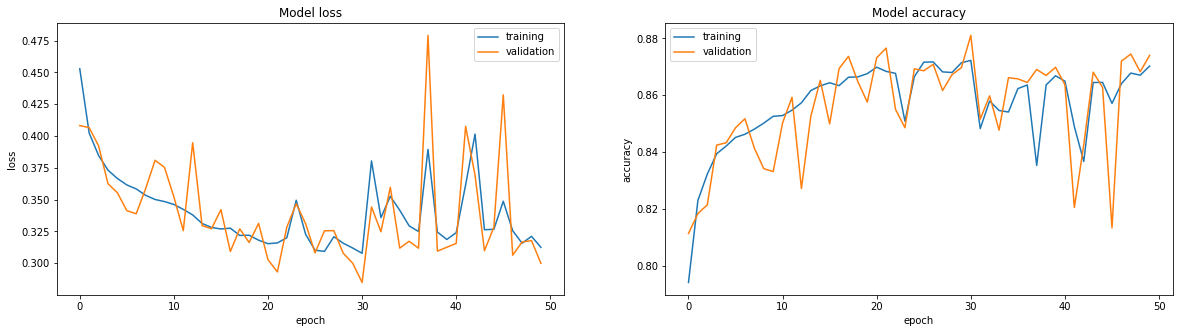

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2998 - accuracy: 0.8740
Validation Accuracy: 0.8740152716636658


In [ ]:
## 4a: Deeper network (input = 32x32)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50) 

**Analysis of graph above (Deeper network)**

The lines of both the training and validation accuracy look pretty messy from a certain point (around epoch=20). 


# Model 5: Batch normalization

We decided to add batch normalization to the previous network to counteract the problem of  the training and validation accuracy fluctuating strongly after epoch 20.

## 5a: Batch normalization

Epoch 1/50
4814/4814 [==============================] - 85s 11ms/step - loss: 0.4409 - accuracy: 0.8106 - val_loss: 0.4492 - val_accuracy: 0.7874
Epoch 2/50
4814/4814 [==============================] - 47s 10ms/step - loss: 0.3722 - accuracy: 0.8417 - val_loss: 0.3793 - val_accuracy: 0.8360
Epoch 3/50
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3426 - accuracy: 0.8560 - val_loss: 0.3352 - val_accuracy: 0.8526
Epoch 4/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3183 - accuracy: 0.8682 - val_loss: 0.5042 - val_accuracy: 0.8334
Epoch 5/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2996 - accuracy: 0.8762 - val_loss: 1.7846 - val_accuracy: 0.7438
Epoch 6/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2896 - accuracy: 0.8819 - val_loss: 0.4473 - val_accuracy: 0.8476
Epoch 7/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2784 - accuracy: 0.8860 - val_loss: 0.3338 - val_

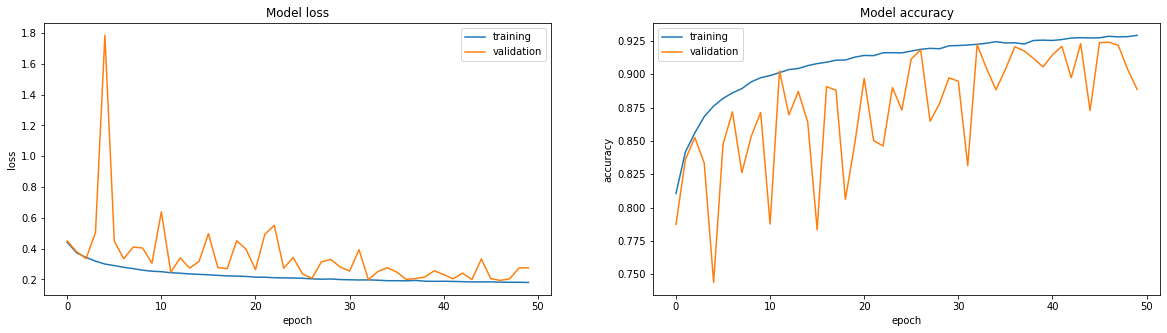

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2753 - accuracy: 0.8886
Validation Accuracy: 0.8886346817016602


In [ ]:
## 5a: Batch normalization
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50) 

**Analysis of the graph above:**

Adding batch normalization did seem to stabilize the traing accuracy as expected. The validation loss and accuracy, however, still fluctuated significanly. We have made several attempts to stabilize both these lines.

## 5b: Batch normalization + lower learning rate

Epoch 1/50
4814/4814 [==============================] - 55s 8ms/step - loss: 0.5039 - accuracy: 0.7812 - val_loss: 0.4179 - val_accuracy: 0.8211
Epoch 2/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.4035 - accuracy: 0.8222 - val_loss: 0.3912 - val_accuracy: 0.8345
Epoch 3/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3770 - accuracy: 0.8352 - val_loss: 0.3976 - val_accuracy: 0.8398
Epoch 4/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3585 - accuracy: 0.8440 - val_loss: 0.3546 - val_accuracy: 0.8521
Epoch 5/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3426 - accuracy: 0.8516 - val_loss: 0.4174 - val_accuracy: 0.8326
Epoch 6/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3286 - accuracy: 0.8593 - val_loss: 0.3854 - val_accuracy: 0.8401
Epoch 7/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3179 - accuracy: 0.8642 - val_loss: 0.4418 - val_ac

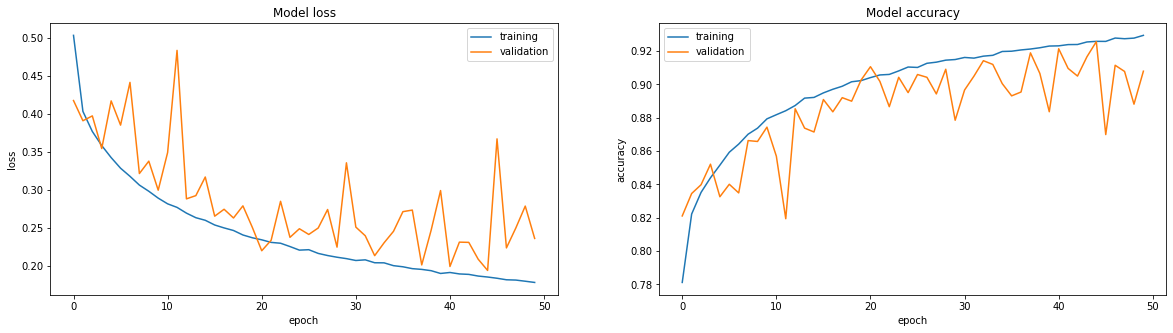

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2359 - accuracy: 0.9079
Validation Accuracy: 0.907935380935669


In [ ]:
## 5b: Batch normalization + lower learning rate
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50, l_rate=0.0001) 

Epoch 1/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.5558 - accuracy: 0.7585 - val_loss: 0.4353 - val_accuracy: 0.8148
Epoch 2/50
4814/4814 [==============================] - 37s 8ms/step - loss: 0.4325 - accuracy: 0.8065 - val_loss: 0.4460 - val_accuracy: 0.8270
Epoch 3/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.4033 - accuracy: 0.8218 - val_loss: 0.4643 - val_accuracy: 0.8299
Epoch 4/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3861 - accuracy: 0.8302 - val_loss: 0.4399 - val_accuracy: 0.8366
Epoch 5/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3710 - accuracy: 0.8382 - val_loss: 0.4676 - val_accuracy: 0.8390
Epoch 6/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3570 - accuracy: 0.8452 - val_loss: 0.4456 - val_accuracy: 0.8386
Epoch 7/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3456 - accuracy: 0.8506 - val_loss: 0.3980 - val_ac

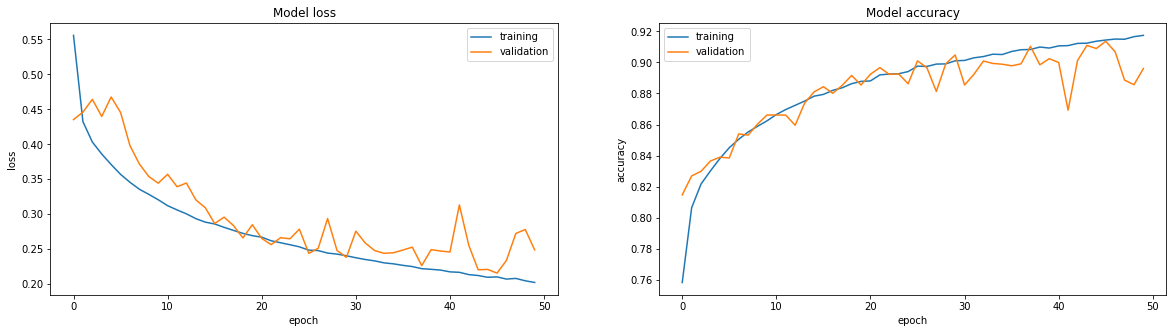

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2490 - accuracy: 0.8961
Validation Accuracy: 0.8960580825805664


In [ ]:
# even lower learning rate:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50, l_rate=0.00005) 

**Analysis of the graphs above (lower learing rate):**

Lowering the learning rate did appear to stabilize the validation loss and accuracy lines/



## 5c: Batch normalization + batch size = 10

Epoch 1/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4377 - accuracy: 0.8130 - val_loss: 0.3945 - val_accuracy: 0.8234
Epoch 2/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3731 - accuracy: 0.8399 - val_loss: 0.4854 - val_accuracy: 0.8122
Epoch 3/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3429 - accuracy: 0.8565 - val_loss: 0.4876 - val_accuracy: 0.7580
Epoch 4/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3176 - accuracy: 0.8684 - val_loss: 0.3369 - val_accuracy: 0.8586
Epoch 5/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3042 - accuracy: 0.8753 - val_loss: 0.5225 - val_accuracy: 0.8281
Epoch 6/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.2888 - accuracy: 0.8822 - val_loss: 0.4862 - val_accuracy: 0.8169
Epoch 7/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.2828 - accuracy: 0.8843 - val_loss: 0.4122 - val_ac

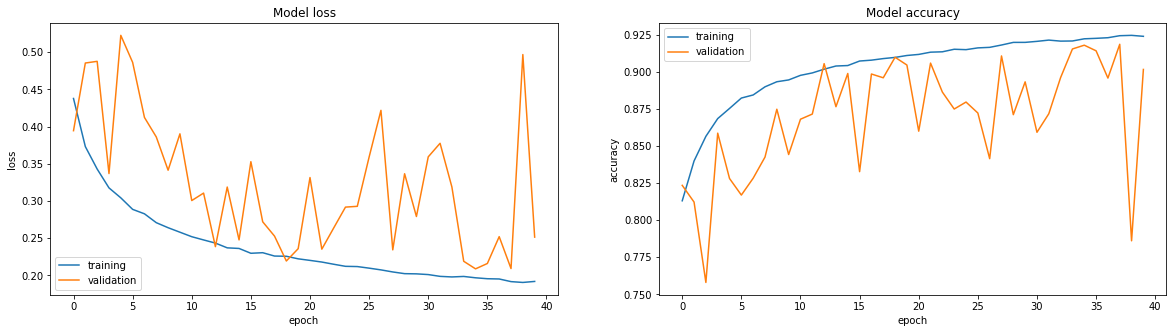

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2515 - accuracy: 0.9015
Validation Accuracy: 0.9015119671821594


In [ ]:
# lower learning rate:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40, batch_size=10) 

## 5d: Batch normalization + batch size = 50

Epoch 1/40
4814/4814 [==============================] - 43s 9ms/step - loss: 0.4397 - accuracy: 0.8112 - val_loss: 0.3695 - val_accuracy: 0.8414
Epoch 2/40
4814/4814 [==============================] - 42s 9ms/step - loss: 0.3725 - accuracy: 0.8423 - val_loss: 0.4368 - val_accuracy: 0.8114
Epoch 3/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.3407 - accuracy: 0.8574 - val_loss: 0.3133 - val_accuracy: 0.8655
Epoch 4/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3184 - accuracy: 0.8688 - val_loss: 0.4857 - val_accuracy: 0.8081
Epoch 5/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3058 - accuracy: 0.8738 - val_loss: 0.3417 - val_accuracy: 0.8582
Epoch 6/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.2908 - accuracy: 0.8803 - val_loss: 0.3549 - val_accuracy: 0.8541
Epoch 7/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.2810 - accuracy: 0.8849 - val_loss: 0.6537 - val_ac

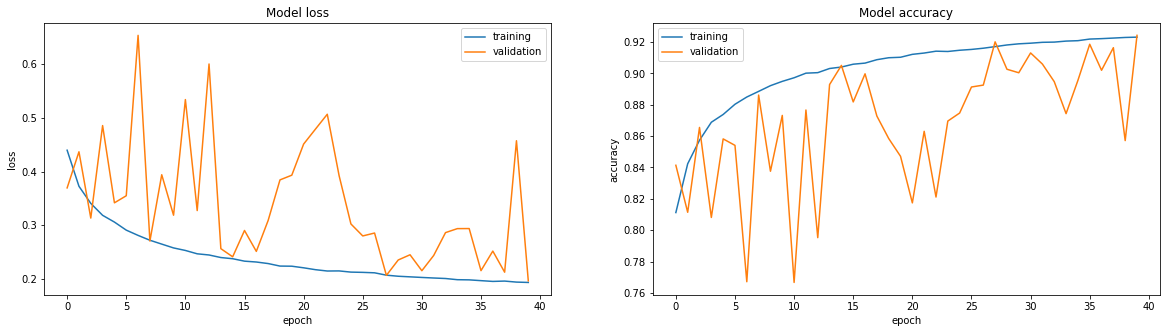

2063/2063 [==============================] - 8s 4ms/step - loss: 0.1963 - accuracy: 0.9242
Validation Accuracy: 0.9242061376571655


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40, batch_size=50) 

## 5e: Batch normalization + L2 regularization

Epoch 1/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.7558 - accuracy: 0.8112 - val_loss: 0.5334 - val_accuracy: 0.7855
Epoch 2/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4770 - accuracy: 0.8372 - val_loss: 0.8310 - val_accuracy: 0.7402
Epoch 3/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4418 - accuracy: 0.8503 - val_loss: 0.4973 - val_accuracy: 0.8262
Epoch 4/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.4046 - accuracy: 0.8588 - val_loss: 0.4117 - val_accuracy: 0.8460
Epoch 5/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3814 - accuracy: 0.8652 - val_loss: 1.0776 - val_accuracy: 0.7259
Epoch 6/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3680 - accuracy: 0.8690 - val_loss: 1.5211 - val_accuracy: 0.6961
Epoch 7/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3612 - accuracy: 0.8705 - val_loss: 0.3672 - val_ac

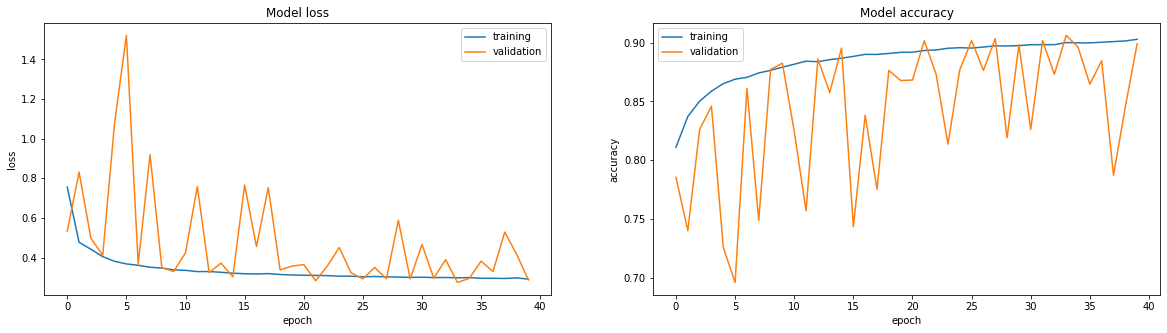

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2872 - accuracy: 0.8991
Validation Accuracy: 0.8990879654884338


In [ ]:
# L2
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2', bias_regularizer='l2'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40) 

**Analysis of the graph above (Batch normalization + ROI=48x48)**
The validation accuracy of the original batch normalization is higher and more stable than with ROI=48x48. Thus, ROI is probably not an improvement

# Model 6: ROI

According to the documentation of our data, the 32x32 centre of the 96x96 images contained at least one pixel of a cancerous cell. We applied the base and batch normalization model to these regions of interest to see whether this would improve the results.

## 6a: Base model


### 6a.b: Base model with ROI = 32x32

Epoch 1/20
4814/4814 [==============================] - 362s 75ms/step - loss: 0.9937 - accuracy: 0.7393 - val_loss: 0.5305 - val_accuracy: 0.7478
Epoch 2/20
4814/4814 [==============================] - 360s 75ms/step - loss: 0.4962 - accuracy: 0.7687 - val_loss: 0.4857 - val_accuracy: 0.7739
Epoch 3/20
4814/4814 [==============================] - 400s 83ms/step - loss: 0.4807 - accuracy: 0.7772 - val_loss: 0.4744 - val_accuracy: 0.7804
Epoch 4/20
4814/4814 [==============================] - 416s 87ms/step - loss: 0.4699 - accuracy: 0.7845 - val_loss: 0.4632 - val_accuracy: 0.7865
Epoch 5/20
4814/4814 [==============================] - 388s 81ms/step - loss: 0.4640 - accuracy: 0.7874 - val_loss: 0.4671 - val_accuracy: 0.7839
Epoch 6/20
4814/4814 [==============================] - 451s 94ms/step - loss: 0.4594 - accuracy: 0.7907 - val_loss: 0.4573 - val_accuracy: 0.7909
Epoch 7/20
4814/4814 [==============================] - 405s 84ms/step - loss: 0.4549 - accuracy: 0.7921 - val_loss: 0

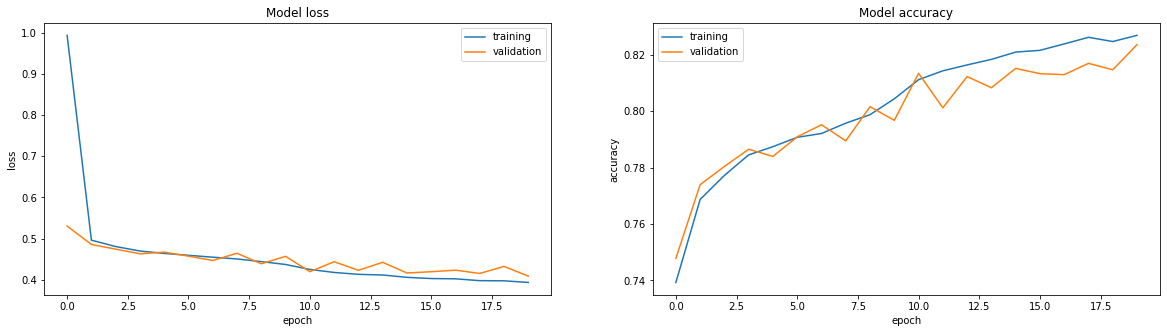

2063/2063 [==============================] - 28s 14ms/step - loss: 0.4088 - accuracy: 0.8235
Validation Accuracy: 0.8235213756561279


In [ ]:
# base model with roi=32x32
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, l_rate=0.001)

### 6a.b: Base model with ROI = 48x48

Epoch 1/20
4814/4814 [==============================] - 72s 12ms/step - loss: 0.9340 - accuracy: 0.7716 - val_loss: 0.5242 - val_accuracy: 0.7612
Epoch 2/20
4814/4814 [==============================] - 46s 10ms/step - loss: 0.4582 - accuracy: 0.7927 - val_loss: 0.4497 - val_accuracy: 0.7950
Epoch 3/20
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4399 - accuracy: 0.8013 - val_loss: 0.4229 - val_accuracy: 0.8093
Epoch 4/20
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4237 - accuracy: 0.8100 - val_loss: 0.4248 - val_accuracy: 0.8129
Epoch 5/20
4814/4814 [==============================] - 43s 9ms/step - loss: 0.4123 - accuracy: 0.8160 - val_loss: 0.4159 - val_accuracy: 0.8127
Epoch 6/20
4814/4814 [==============================] - 42s 9ms/step - loss: 0.4016 - accuracy: 0.8218 - val_loss: 0.4142 - val_accuracy: 0.8172
Epoch 7/20
4814/4814 [==============================] - 42s 9ms/step - loss: 0.3933 - accuracy: 0.8253 - val_loss: 0.4036 - val_

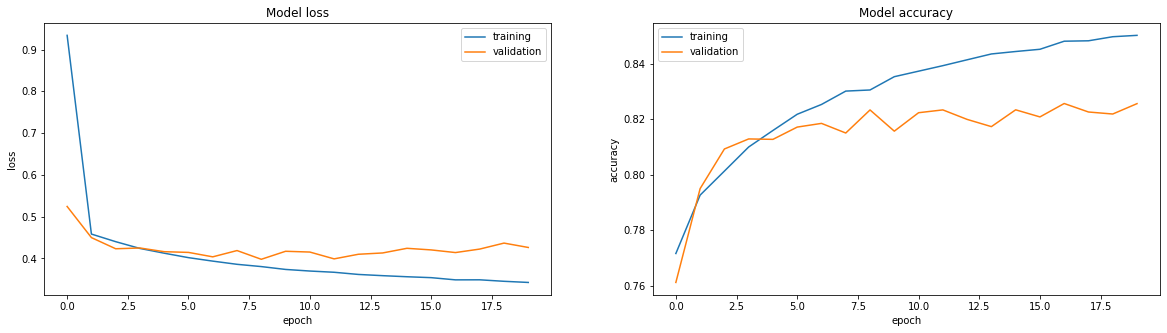

2063/2063 [==============================] - 5s 3ms/step - loss: 0.4260 - accuracy: 0.8256
Validation Accuracy: 0.8256272077560425


In [ ]:
# base model with ROI=48x48
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels)

## 6b: Batch normalization


### 6b.a Batch normalization with ROI = 32x32

Epoch 1/40
4814/4814 [==============================] - 58s 9ms/step - loss: 0.4885 - accuracy: 0.7834 - val_loss: 0.4478 - val_accuracy: 0.8028
Epoch 2/40
4814/4814 [==============================] - 41s 9ms/step - loss: 0.4388 - accuracy: 0.8073 - val_loss: 0.4843 - val_accuracy: 0.7708
Epoch 3/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.4176 - accuracy: 0.8186 - val_loss: 0.3895 - val_accuracy: 0.8364
Epoch 4/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.3947 - accuracy: 0.8295 - val_loss: 0.4650 - val_accuracy: 0.8145
Epoch 5/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.3822 - accuracy: 0.8371 - val_loss: 0.4221 - val_accuracy: 0.8139
Epoch 6/40
4814/4814 [==============================] - 41s 9ms/step - loss: 0.3717 - accuracy: 0.8413 - val_loss: 0.3991 - val_accuracy: 0.8277
Epoch 7/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.3646 - accuracy: 0.8447 - val_loss: 0.3434 - val_ac

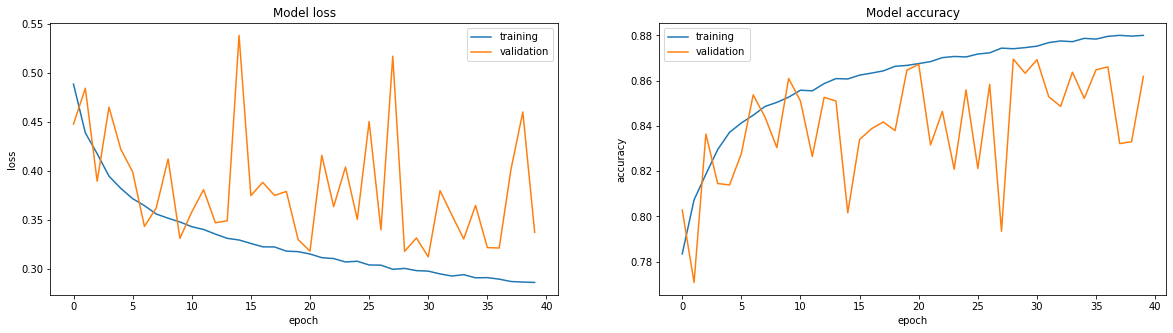

2063/2063 [==============================] - 8s 4ms/step - loss: 0.3374 - accuracy: 0.8619
Validation Accuracy: 0.861865222454071


In [ ]:
## Batch normalization + ROI = 32x32
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40) 

### 6.b.b Batch normalization + ROI = 32x32 + lower learning rate


Epoch 1/40
4814/4814 [==============================] - 45s 9ms/step - loss: 0.5338 - accuracy: 0.7578 - val_loss: 0.4967 - val_accuracy: 0.7821
Epoch 2/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4580 - accuracy: 0.7928 - val_loss: 0.4580 - val_accuracy: 0.8079
Epoch 3/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4380 - accuracy: 0.8041 - val_loss: 0.4275 - val_accuracy: 0.8174
Epoch 4/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4245 - accuracy: 0.8109 - val_loss: 0.4332 - val_accuracy: 0.8186
Epoch 5/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.4113 - accuracy: 0.8182 - val_loss: 0.4177 - val_accuracy: 0.8162
Epoch 6/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.3998 - accuracy: 0.8245 - val_loss: 0.3925 - val_accuracy: 0.8278
Epoch 7/40
4814/4814 [==============================] - 44s 9ms/step - loss: 0.3889 - accuracy: 0.8306 - val_loss: 0.3936 - val_ac

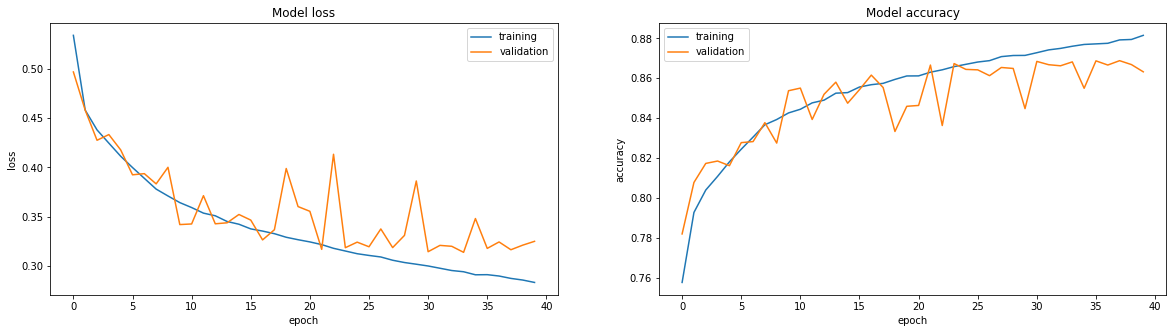

2063/2063 [==============================] - 8s 4ms/step - loss: 0.3250 - accuracy: 0.8632
Validation Accuracy: 0.8632286787033081


In [ ]:
## Batch normalization + ROI = 32x32 + lower learning rate
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40, l_rate=0.0001) 

### 6b.c Batch normalization with ROI = 48x48

Epoch 1/40
4814/4814 [==============================] - 70s 11ms/step - loss: 0.4621 - accuracy: 0.8021 - val_loss: 0.4940 - val_accuracy: 0.7568
Epoch 2/40
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3978 - accuracy: 0.8306 - val_loss: 0.4173 - val_accuracy: 0.8317
Epoch 3/40
4814/4814 [==============================] - 51s 11ms/step - loss: 0.3664 - accuracy: 0.8464 - val_loss: 0.3494 - val_accuracy: 0.8517
Epoch 4/40
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3409 - accuracy: 0.8590 - val_loss: 0.3971 - val_accuracy: 0.8328
Epoch 5/40
4814/4814 [==============================] - 49s 10ms/step - loss: 0.3232 - accuracy: 0.8680 - val_loss: 0.3351 - val_accuracy: 0.8581
Epoch 6/40
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3094 - accuracy: 0.8727 - val_loss: 0.3995 - val_accuracy: 0.8473
Epoch 7/40
4814/4814 [==============================] - 52s 11ms/step - loss: 0.2992 - accuracy: 0.8783 - val_loss: 0.2861 -

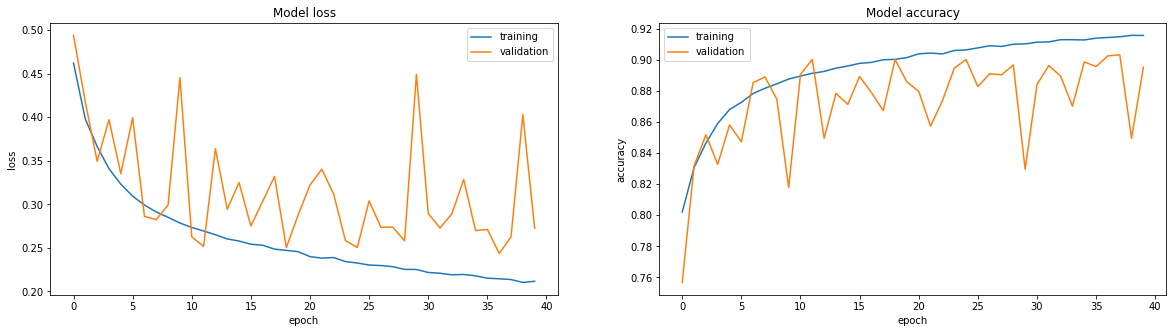

2063/2063 [==============================] - 7s 3ms/step - loss: 0.2726 - accuracy: 0.8953
Validation Accuracy: 0.8952551484107971


In [ ]:
## ROI = 48x48
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40) 

**Analysis of the graphs above (ROI):**

Focussing our model on the region of interest did not seem to improve our model. This is not very surprising, as the network can learn what area is relevant. We have decided not to focus the following models on the ROI, as we do not want the model to loose input information.

# Model 7: Data augmentation

Since cropping images to a region of interest did not prove itself very useful for our project, we began experimenting with data augmentation.

Data augmentations we hypothesized to be relevant were:
- Horizontal and vertical flips
- Zoom
- Rotation

##7a: Horizontal and vertical flip

Epoch 1/70
4814/4814 [==============================] - 69s 14ms/step - loss: 0.4368 - accuracy: 0.8126 - val_loss: 0.3788 - val_accuracy: 0.8310
Epoch 2/70
4814/4814 [==============================] - 64s 13ms/step - loss: 0.3782 - accuracy: 0.8397 - val_loss: 0.7610 - val_accuracy: 0.6998
Epoch 3/70
4814/4814 [==============================] - 61s 13ms/step - loss: 0.3490 - accuracy: 0.8537 - val_loss: 1.4384 - val_accuracy: 0.6364
Epoch 4/70
4814/4814 [==============================] - 62s 13ms/step - loss: 0.3304 - accuracy: 0.8627 - val_loss: 0.5078 - val_accuracy: 0.7924
Epoch 5/70
4814/4814 [==============================] - 64s 13ms/step - loss: 0.3155 - accuracy: 0.8700 - val_loss: 0.8481 - val_accuracy: 0.7394
Epoch 6/70
4814/4814 [==============================] - 72s 15ms/step - loss: 0.3029 - accuracy: 0.8757 - val_loss: 0.2973 - val_accuracy: 0.8774
Epoch 7/70
4814/4814 [==============================] - 63s 13ms/step - loss: 0.2934 - accuracy: 0.8794 - val_loss: 1.6732 -

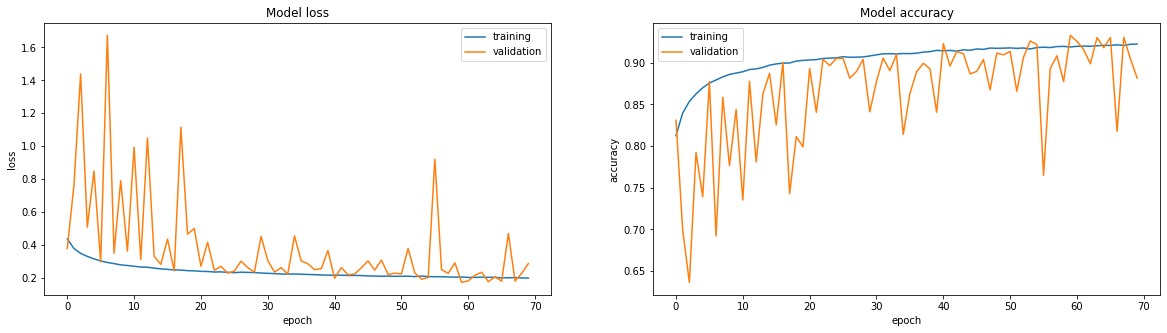

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2873 - accuracy: 0.8817
Validation Accuracy: 0.8817264437675476


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=60) 

## 7b: Zoom range

Epoch 1/60
4814/4814 [==============================] - 99s 20ms/step - loss: 0.4749 - accuracy: 0.7893 - val_loss: 1.2667 - val_accuracy: 0.6212
Epoch 2/60
4814/4814 [==============================] - 98s 20ms/step - loss: 0.4053 - accuracy: 0.8247 - val_loss: 0.9596 - val_accuracy: 0.6062
Epoch 3/60
4814/4814 [==============================] - 98s 20ms/step - loss: 0.3688 - accuracy: 0.8430 - val_loss: 0.7248 - val_accuracy: 0.7188
Epoch 4/60
4814/4814 [==============================] - 98s 20ms/step - loss: 0.3503 - accuracy: 0.8513 - val_loss: 0.6009 - val_accuracy: 0.8086
Epoch 5/60
4814/4814 [==============================] - 97s 20ms/step - loss: 0.3367 - accuracy: 0.8588 - val_loss: 0.6276 - val_accuracy: 0.8000
Epoch 6/60
4814/4814 [==============================] - 97s 20ms/step - loss: 0.3246 - accuracy: 0.8641 - val_loss: 0.3967 - val_accuracy: 0.8445
Epoch 7/60
4814/4814 [==============================] - 97s 20ms/step - loss: 0.3171 - accuracy: 0.8663 - val_loss: 0.4317 -

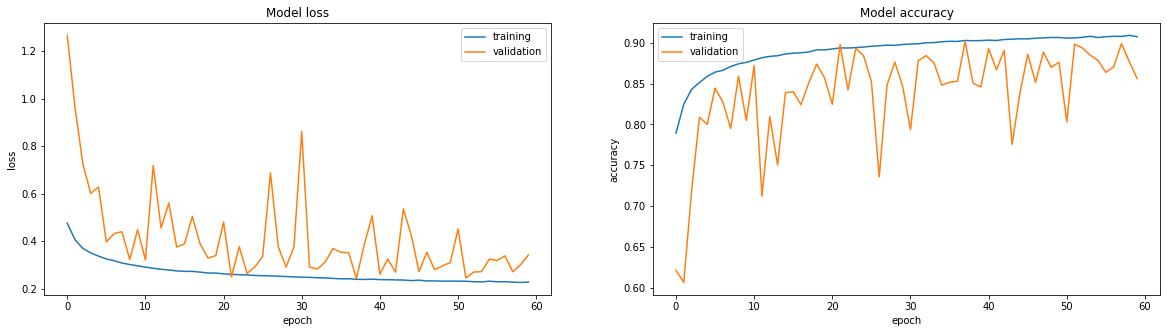

2063/2063 [==============================] - 8s 4ms/step - loss: 0.3419 - accuracy: 0.8561
Validation Accuracy: 0.8561235070228577


In [ ]:
# Zoom range
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'zoom_range': 0.2}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=40) 

##  7c: Rotation range

Epoch 1/40
4814/4814 [==============================] - 132s 24ms/step - loss: 0.4535 - accuracy: 0.8030 - val_loss: 1.5445 - val_accuracy: 0.6043
Epoch 2/40
4814/4814 [==============================] - 114s 24ms/step - loss: 0.4006 - accuracy: 0.8274 - val_loss: 1.2752 - val_accuracy: 0.6376
Epoch 3/40
4814/4814 [==============================] - 115s 24ms/step - loss: 0.3707 - accuracy: 0.8411 - val_loss: 0.9078 - val_accuracy: 0.6487
Epoch 4/40
4814/4814 [==============================] - 118s 25ms/step - loss: 0.3480 - accuracy: 0.8524 - val_loss: 2.4954 - val_accuracy: 0.6173
Epoch 5/40
4814/4814 [==============================] - 119s 25ms/step - loss: 0.3333 - accuracy: 0.8599 - val_loss: 1.1461 - val_accuracy: 0.6356
Epoch 6/40
4814/4814 [==============================] - 114s 24ms/step - loss: 0.3211 - accuracy: 0.8653 - val_loss: 0.5772 - val_accuracy: 0.7592
Epoch 7/40
4814/4814 [==============================] - 114s 24ms/step - loss: 0.3118 - accuracy: 0.8699 - val_loss: 0

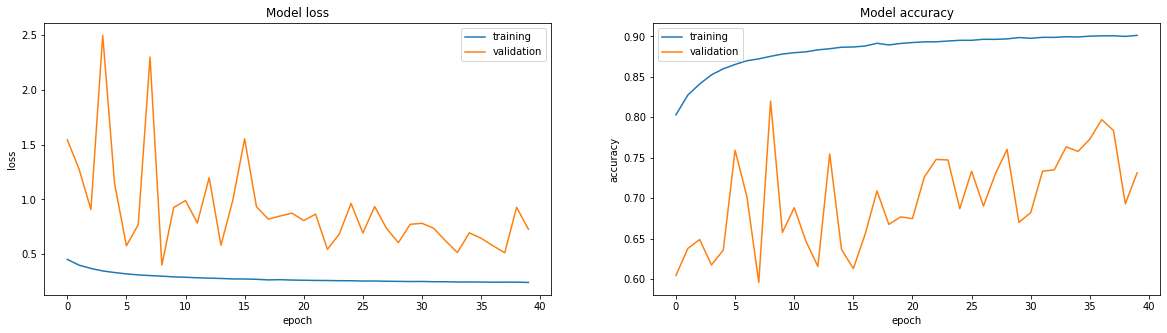

2063/2063 [==============================] - 8s 4ms/step - loss: 0.7284 - accuracy: 0.7313
Validation Accuracy: 0.7312901616096497


In [ ]:
## Rotation range
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'rotation_range': 20}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=40) 

**Analysis of the graphs above (Data augmentation)**

The rotation range augmentation does not improve the performance of our model at all. The other two do not seem to have a strong influence on the model performance. This may be because the dataset already contains a wide variety of sample images.

# Model 8: Deeper again

## 8a: Extra hidden layer

Epoch 1/70
4814/4814 [==============================] - 39s 8ms/step - loss: 0.4914 - accuracy: 0.7793 - val_loss: 0.4158 - val_accuracy: 0.8280
Epoch 2/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4035 - accuracy: 0.8240 - val_loss: 0.4033 - val_accuracy: 0.8399
Epoch 3/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3770 - accuracy: 0.8358 - val_loss: 0.3467 - val_accuracy: 0.8499
Epoch 4/70
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3593 - accuracy: 0.8452 - val_loss: 0.3740 - val_accuracy: 0.8493
Epoch 5/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3467 - accuracy: 0.8509 - val_loss: 0.4213 - val_accuracy: 0.8295
Epoch 6/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3334 - accuracy: 0.8574 - val_loss: 0.3861 - val_accuracy: 0.8505
Epoch 7/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3236 - accuracy: 0.8633 - val_loss: 0.3605 - val_ac

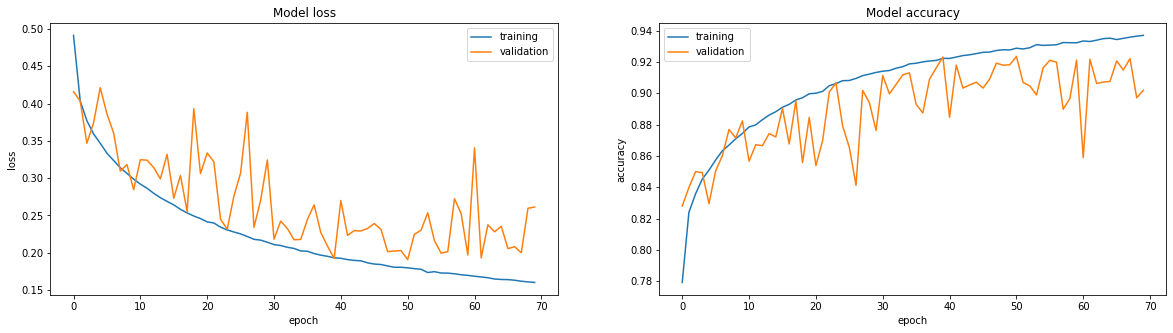

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2612 - accuracy: 0.9019
Validation Accuracy: 0.9018906950950623


In [ ]:
# deeper dense
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, 
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=70, l_rate=0.0001) 

## 8b: Higher dropout

Epoch 1/70
4814/4814 [==============================] - 39s 8ms/step - loss: 0.6217 - accuracy: 0.7368 - val_loss: 0.4707 - val_accuracy: 0.8084
Epoch 2/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4380 - accuracy: 0.8075 - val_loss: 0.4346 - val_accuracy: 0.8252
Epoch 3/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4024 - accuracy: 0.8251 - val_loss: 0.3793 - val_accuracy: 0.8425
Epoch 4/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3813 - accuracy: 0.8358 - val_loss: 0.3905 - val_accuracy: 0.8512
Epoch 5/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3647 - accuracy: 0.8430 - val_loss: 0.3671 - val_accuracy: 0.8552
Epoch 6/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3516 - accuracy: 0.8495 - val_loss: 0.3401 - val_accuracy: 0.8499
Epoch 7/70
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3411 - accuracy: 0.8550 - val_loss: 0.3530 - val_ac

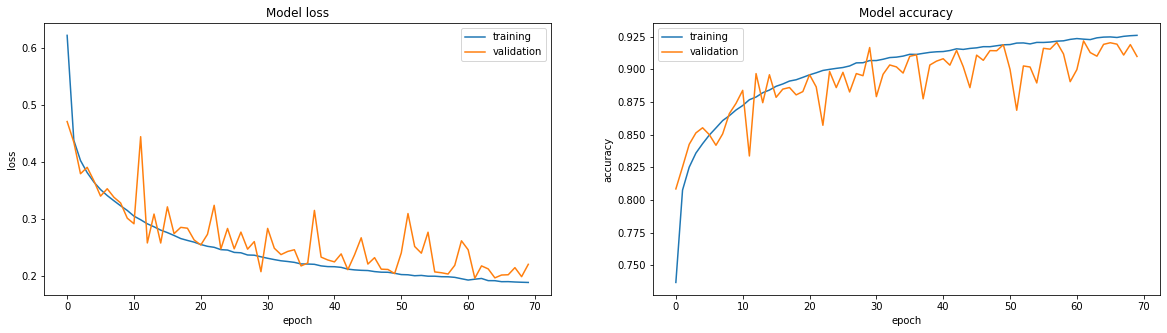

2063/2063 [==============================] - 10s 5ms/step - loss: 0.2206 - accuracy: 0.9098
Validation Accuracy: 0.9097533822059631


In [ ]:
# higher dropout
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, 
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=70, l_rate=0.0001) 

Epoch 1/70
4814/4814 [==============================] - 53s 11ms/step - loss: 0.6334 - accuracy: 0.7381 - val_loss: 0.5354 - val_accuracy: 0.7460
Epoch 2/70
4814/4814 [==============================] - 51s 11ms/step - loss: 0.4402 - accuracy: 0.8064 - val_loss: 0.4095 - val_accuracy: 0.8222
Epoch 3/70
4814/4814 [==============================] - 51s 11ms/step - loss: 0.4017 - accuracy: 0.8257 - val_loss: 0.3792 - val_accuracy: 0.8362
Epoch 4/70
4814/4814 [==============================] - 51s 11ms/step - loss: 0.3801 - accuracy: 0.8351 - val_loss: 0.3569 - val_accuracy: 0.8536
Epoch 5/70
4814/4814 [==============================] - 51s 11ms/step - loss: 0.3614 - accuracy: 0.8443 - val_loss: 0.3857 - val_accuracy: 0.8332
Epoch 6/70
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3518 - accuracy: 0.8503 - val_loss: 0.3634 - val_accuracy: 0.8272
Epoch 7/70
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3407 - accuracy: 0.8550 - val_loss: 0.3233 -

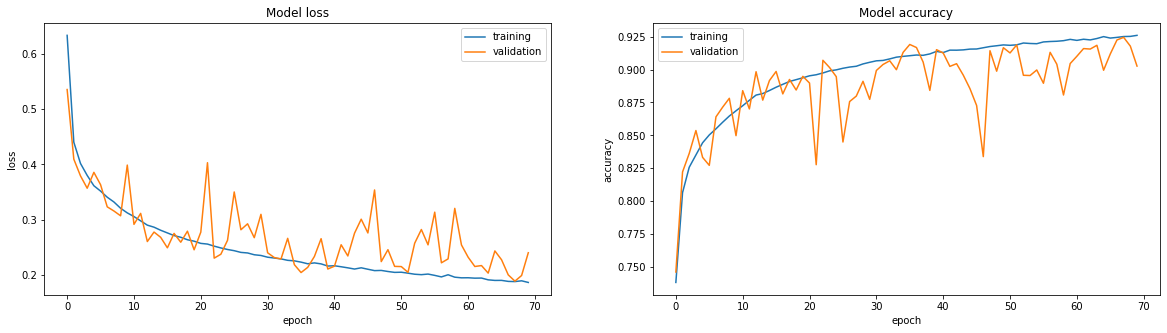

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2403 - accuracy: 0.9026
Validation Accuracy: 0.9026481509208679


In [ ]:
# higher dropout and data augment
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True,
       'zoom': 0.1}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, 
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=70, l_rate=0.0001) 

# Model evaluation

For the final evaluation we ran model 5b and 8b again with 100 epochs, and also an extra iteration with Adagrad as optimizer

## Batchnorm with 100 epochs




Epoch 1/100
4814/4814 [==============================] - 42s 8ms/step - loss: 0.5043 - accuracy: 0.7783 - recall: 0.6933 - val_loss: 0.4271 - val_accuracy: 0.8086 - val_recall: 0.8375
Epoch 2/100
4814/4814 [==============================] - 40s 8ms/step - loss: 0.4053 - accuracy: 0.8196 - recall: 0.7397 - val_loss: 0.4295 - val_accuracy: 0.8408 - val_recall: 0.7888
Epoch 3/100
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3741 - accuracy: 0.8369 - recall: 0.7700 - val_loss: 0.4083 - val_accuracy: 0.8437 - val_recall: 0.8059
Epoch 4/100
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3547 - accuracy: 0.8468 - recall: 0.7849 - val_loss: 0.3634 - val_accuracy: 0.8498 - val_recall: 0.8309
Epoch 5/100
4814/4814 [==============================] - 40s 8ms/step - loss: 0.3404 - accuracy: 0.8553 - recall: 0.7994 - val_loss: 0.4181 - val_accuracy: 0.8254 - val_recall: 0.8632
Epoch 6/100
4814/4814 [==============================] - 39s 8ms/step - loss: 0.

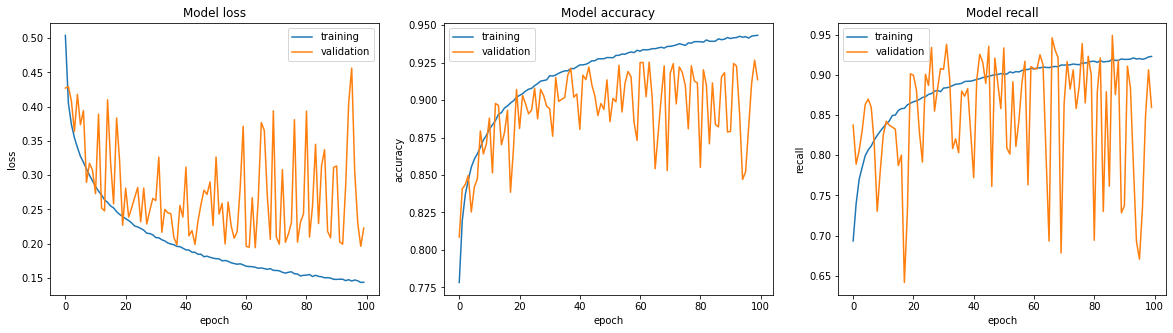

In [ ]:
# batchnorm + more epochs
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=100, l_rate=0.0001) 


## Deeper batchnorm with 100 epochs


Epoch 1/100
4814/4814 [==============================] - 42s 9ms/step - loss: 0.6381 - accuracy: 0.7325 - recall: 0.6437 - val_loss: 0.4681 - val_accuracy: 0.8082 - val_recall: 0.7813
Epoch 2/100
4814/4814 [==============================] - 42s 9ms/step - loss: 0.4432 - accuracy: 0.8047 - recall: 0.7098 - val_loss: 0.4280 - val_accuracy: 0.8002 - val_recall: 0.8818
Epoch 3/100
4814/4814 [==============================] - 42s 9ms/step - loss: 0.4067 - accuracy: 0.8226 - recall: 0.7434 - val_loss: 0.3857 - val_accuracy: 0.8444 - val_recall: 0.7925
Epoch 4/100
4814/4814 [==============================] - 41s 9ms/step - loss: 0.3825 - accuracy: 0.8339 - recall: 0.7639 - val_loss: 0.3923 - val_accuracy: 0.8387 - val_recall: 0.7765
Epoch 5/100
4814/4814 [==============================] - 41s 9ms/step - loss: 0.3668 - accuracy: 0.8430 - recall: 0.7777 - val_loss: 0.3431 - val_accuracy: 0.8569 - val_recall: 0.8509
Epoch 6/100
4814/4814 [==============================] - 41s 9ms/step - loss: 0.

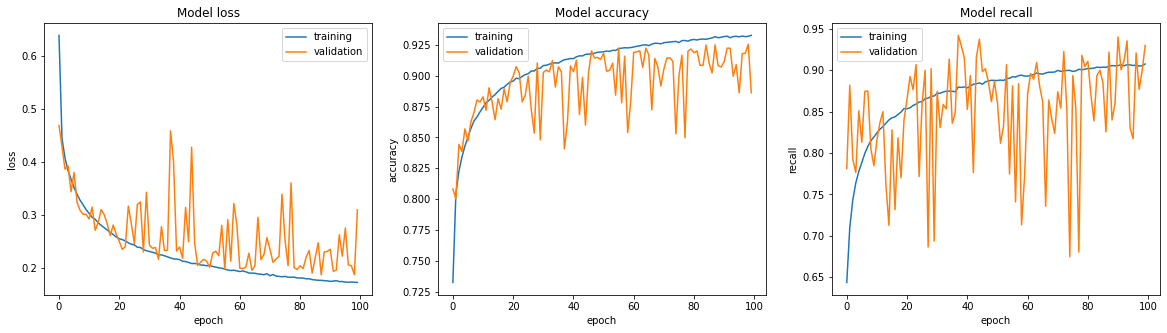

In [ ]:
# dieper + higher dropout + lower learning rate
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, 
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=100, l_rate=0.0001) 

## Batchnorm with Adagrad

Epoch 1/100
4814/4814 [==============================] - 50s 7ms/step - loss: 1.2894 - accuracy: 0.5940 - recall: 0.1074 - val_loss: 0.6314 - val_accuracy: 0.6637 - val_recall: 0.3057
Epoch 2/100
4814/4814 [==============================] - 34s 7ms/step - loss: 1.0804 - accuracy: 0.6183 - recall: 0.2236 - val_loss: 0.5955 - val_accuracy: 0.6861 - val_recall: 0.6971
Epoch 3/100
4814/4814 [==============================] - 33s 7ms/step - loss: 0.9600 - accuracy: 0.6408 - recall: 0.3255 - val_loss: 0.6410 - val_accuracy: 0.6543 - val_recall: 0.8266
Epoch 4/100
4814/4814 [==============================] - 33s 7ms/step - loss: 0.8938 - accuracy: 0.6571 - recall: 0.4010 - val_loss: 0.6848 - val_accuracy: 0.6389 - val_recall: 0.8778
Epoch 5/100
4814/4814 [==============================] - 34s 7ms/step - loss: 0.8466 - accuracy: 0.6695 - recall: 0.4548 - val_loss: 0.7182 - val_accuracy: 0.6319 - val_recall: 0.9041
Epoch 6/100
4814/4814 [==============================] - 34s 7ms/step - loss: 0.

NameError: ignored

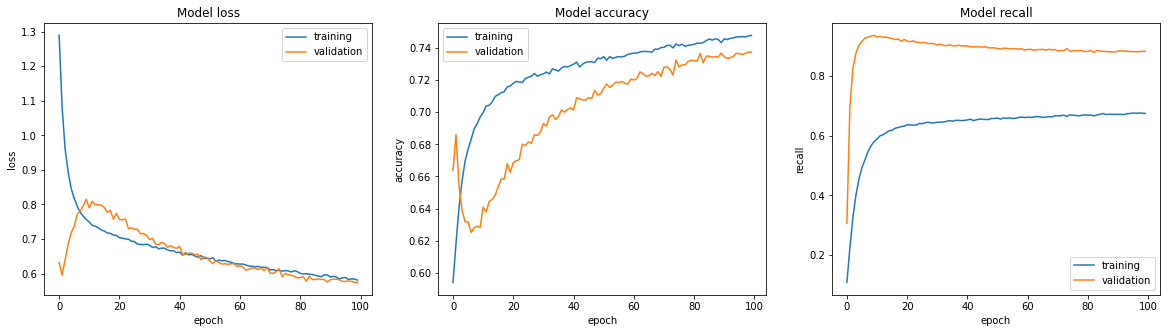

In [ ]:
# batchnorm + adagrad:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

m1_ada = train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=100, l_rate=0.0001) 


## Deeper batchnorm with adagrad

Epoch 1/100
4814/4814 [==============================] - 36s 7ms/step - loss: 1.5193 - accuracy: 0.5565 - recall: 0.4458 - val_loss: 0.5888 - val_accuracy: 0.6865 - val_recall: 0.7291
Epoch 2/100
4814/4814 [==============================] - 35s 7ms/step - loss: 1.3307 - accuracy: 0.5956 - recall: 0.4872 - val_loss: 0.6135 - val_accuracy: 0.6946 - val_recall: 0.7834
Epoch 3/100
4814/4814 [==============================] - 35s 7ms/step - loss: 1.2278 - accuracy: 0.6196 - recall: 0.5162 - val_loss: 0.6183 - val_accuracy: 0.7044 - val_recall: 0.8132
Epoch 4/100
4814/4814 [==============================] - 35s 7ms/step - loss: 1.1513 - accuracy: 0.6341 - recall: 0.5328 - val_loss: 0.6168 - val_accuracy: 0.7150 - val_recall: 0.8321
Epoch 5/100
4814/4814 [==============================] - 34s 7ms/step - loss: 1.0889 - accuracy: 0.6496 - recall: 0.5552 - val_loss: 0.6069 - val_accuracy: 0.7214 - val_recall: 0.8427
Epoch 6/100
4814/4814 [==============================] - 34s 7ms/step - loss: 1.

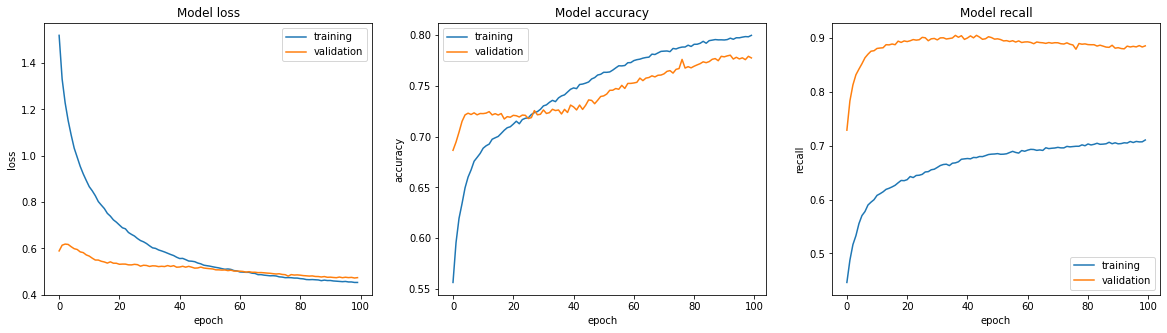

In [ ]:
# Deeper batchnorm + adagrad
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

m2_ada = train_and_evaluate(model, train_images, train_labels, val_images, val_labels, 
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=100, l_rate=0.001) 

**Analysis of the graphs above (Model evaluation)**


Of the contesting models, we think that the deeper bachnormalization with the standard adam optimizer is the best model, as the training and validation accuracy allign the most. 
